## **Mathematical Formulation**

### **Decision Variables**
Let:
- $ X_{ij} \in \mathbb{Z}^+ $ : Number of units shipped by land from city $ i $ to city $ j $.
- $ Y_j \in \mathbb{Z}^+ $ : Number of units shipped by sea arriving at city $ j $.
- $ p_i \in \mathbb{Z}^+ $ : Production units at city $ i $.
- $ z_i \in \{0,1\} $ : Binary variable indicating if city $ i $ is producing.
- $ e^{S}_j, e^{L}_j \in \{0,1\} $ : Binary variable for extra small ($ e^S $) and large ($ e^L $) containers at city $ j $.
- $ \alpha_j, \beta_j \in \mathbb{Z}^+ $ : The number of large and small containers at city $ j $.
- $ d_j, r_j \in \mathbb{Z}^+ $ : Difference and remainder variables for container constraints.

### Constants
- **Demand vector:** $ \mathbf{D} $  
- **Manufacturing cost vector:** $ \mathbf{m} $ (per city), with $ m_0 $ representing sea-based manufacturing costs  
- **Shipping cost vector:** $ \mathbf{S} $  
  - $ S^S $ for small containers  
  - $ S^L $ for large containers  
  - $ S^D $ for LCL (less-than-container-load) shipping  
- **Lead time vector:** $ \mathbf{L} $  
- **Land cost matrix:** $ \mathbf{R} $  

### **Objective Function**
Minimize total costs:
$$
\begin{align}
\min \quad 
& \sum_{i,j} R_{ij} X_{ij} 
+ \sum_{i} \left[ S^L_i (\alpha_i + e^L_i) + S^S_i (\beta_i + e^S_i) + S^D_i d_i \right] \\
& + \sum_{i} \left[ 500 z_i m_i + Y_i m_0 \right] 
+ \sum_{i} \left[ 0.15 \cdot L_i \cdot m_0 \cdot \left((\alpha_i + e^L_i) \cdot 200 + (\beta_i + e^S_i) \cdot 100 \right) \right]
\end{align}
$$

### **Constraints**

#### **Demand Constraints:**
$$
500 z_i + \sum_{i \neq j} X_{ij} + Y_j - \sum_{i \neq j} X_{ji}  \geq D_j, \quad \forall j
$$

#### **Production Constraints:**
$$
\sum_{i} z_i \le 1
$$

#### **Shipping Size Logic:**
$$
Y_i = 200 \alpha_i + 100 \beta_i + r_i, \quad \forall i
$$
$$
e^{S}_i + e^{L}_i \leq 1, \quad \forall i
$$
$$
d_i + r_i \ge 200 e^{L}_i, \quad \forall i
$$
$$
d_i + r_i \ge 100 e^{S}_i, \quad \forall i
$$

#### **Non-Negativity Constraints:**
$$
X_{ij}, Y_j, p_i, z_i, \alpha_j, \beta_j, d_j, r_j, e^{S}_j, e^{L}_j \geq 0, \quad \forall i,j
$$


Alternatively, you can open the notebook directly in Google Colab by clicking the button below:

<a href="https://colab.research.google.com/github/wweissbluth/CMOR-461-LOGISTICS-AND-SUPPLY-CHAIN-MANAGEMENT/blob/main/hw4.ipynb" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" width="200">
</a>

In [140]:
# Demand vector (D)
D = {
    "Adelaide": 420,
    "Brisbane": 870,
    "Melbourne": 1250,
    "Perth": 930,
    "Sydney": 1310
}

# Manufacturing cost vector (m), with m_0 for sea delivery
m = {
    "Adelaide": 450,
    "Brisbane": 480,
    "Melbourne": 505,
    "Perth": 490,
    "Sydney": 515,
    "Ovis": 440  # Sea-delivered
}

# Shipping cost vector (S)
S_L = {  # Large Containers (40')
    "Adelaide": 2000,
    "Brisbane": 1600,
    "Melbourne": 1800,
    "Perth": 1200,
    "Sydney": 1650
}

S_S = {  # Small Containers (20')
    "Adelaide": 1200,
    "Brisbane": 1000,
    "Melbourne": 1100,
    "Perth": 700,
    "Sydney": 1050
}

S_Delta = {  # LCL Unit Shipping
    "Adelaide": 25,
    "Brisbane": 20,
    "Melbourne": 23,
    "Perth": 15,
    "Sydney": 22
}

# Lead Time vector (L)
L = {
    "Adelaide": 30,
    "Brisbane": 21,
    "Melbourne": 28,
    "Perth": 18,
    "Sydney": 25
}

# Land Cost Matrix (R)
R = {
    "Adelaide":     {"Adelaide": 0,  "Brisbane": 35, "Melbourne": 10, "Perth": 35, "Sydney": 25},
    "Brisbane":     {"Adelaide": 35, "Brisbane": 0,  "Melbourne": 25, "Perth": 70, "Sydney": 15},
    "Melbourne":    {"Adelaide": 10, "Brisbane": 25, "Melbourne": 0,  "Perth": 45, "Sydney": 15},
    "Perth":        {"Adelaide": 35, "Brisbane": 70, "Melbourne": 45, "Perth": 0,  "Sydney": 55},
    "Sydney":       {"Adelaide": 25, "Brisbane": 15, "Melbourne": 15, "Perth": 55, "Sydney": 0}
}

In [141]:
from gurobipy import Model, GRB

# Define cities
cities = ["Adelaide", "Brisbane", "Melbourne", "Perth", "Sydney"]

# Initialize Gurobi Model
model = Model("Shipping_Optimization")

# Decision Variables
X = model.addVars(cities, cities, vtype=GRB.INTEGER, name="X")  # Land shipping
Y = model.addVars(cities, vtype=GRB.INTEGER, name="Y")  # Sea shipping
z = model.addVars(cities, vtype=GRB.BINARY, name="z")  # Production indicator

eS = model.addVars(cities, vtype=GRB.BINARY, name="eS")  # Small extra container indicator
eL = model.addVars(cities, vtype=GRB.BINARY, name="eL")  # Large extra container indicator

alpha = model.addVars(cities, vtype=GRB.INTEGER, name="alpha")  # Large container count
beta = model.addVars(cities, vtype=GRB.INTEGER, name="beta")  # Small container count

d = model.addVars(cities, vtype=GRB.INTEGER, name="d")  # Difference variable
r = model.addVars(cities, vtype=GRB.INTEGER, name="r")  # Remainder variable

# Constraint: X_ij when i = j is always 0
for city in cities:
    model.addConstr(X[city, city] == 0, name=f"NoSelfShipping_{city}")

# Objective Function: Minimize total cost
model.setObjective(
    sum(R[i][j] * X[i, j] for i in cities for j in cities) + # Land Shipping Cost
    sum(S_L[i] * (alpha[i] + eL[i]) + S_S[i] * (beta[i] + eS[i]) + S_Delta[i] * d[i] for i in cities) + # Sea Shipping
    sum(500 * z[i] * m[i] + Y[i] * m["Ovis"] for i in cities) + # Manufacturing Cost
    sum(0.15 * L[i] * m["Ovis"] * ((alpha[i] + eL[i]) * 200 + (beta[i] + eS[i]) * 100) for i in cities), # Holding Cost
    GRB.MINIMIZE
)

# Demand Constraints
for j in cities:
    model.addConstr(
        (500 * z[j] + sum(X[i, j] for i in cities if i != j) + Y[j]) - sum(X[j, k] for k in cities if k != j) >= D[j],
        name=f"Demand_{j}"
    )

# Production Constraint: Only one city can be producing
model.addConstr(sum(z[i] for i in cities) <= 1, name="Production_Limit")

# Shipping Size Logic
for i in cities:
    model.addConstr(Y[i] == 200 * alpha[i] + 100 * beta[i] + r[i], name=f"Container_Size_{i}")
    model.addConstr(eS[i] + eL[i] <= 1, name=f"Container_Type_{i}") # Only one container type can be used - OPTIONAL
    model.addConstr(d[i] + r[i] == 200 * eL[i]+100 * eS[i], name=f"Container_Min_{i}")


# Non-negativity Constraints
for var in [X, Y, alpha, beta, d, r]:
    for key in var:
        model.addConstr(var[key] >= 0, name=f"NonNegative_{key}")

# Optimize Model
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 76 rows, 65 columns and 160 nonzeros
Model fingerprint: 0x0f4cfa5d
Variable types: 0 continuous, 65 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1.093925e+07
Presolve removed 55 rows and 10 columns
Presolve time: 0.00s
Presolved: 21 rows, 55 columns, 100 nonzeros
Variable types: 0 continuous, 55 integer (15 binary)

Root relaxation: objective 7.402420e+06, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7402420.00    0    1 1.0939e+07 7402420.00  32.3

In [142]:
# Print Results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    print(f"Total Cost: {model.objVal}")
    
    # Collect results
    X_values = {i: {j: X[i, j].x for j in cities} for i in cities}
    Y_values = {i: Y[i].x for i in cities}
    z_values = {i: z[i].x for i in cities}
    eS_values = {i: eS[i].x for i in cities}
    eL_values = {i: eL[i].x for i in cities}
    alpha_values = {i: alpha[i].x for i in cities}
    beta_values = {i: beta[i].x for i in cities}
    d_values = {i: d[i].x for i in cities}
    r_values = {i: r[i].x for i in cities}

    # Print results
    print("X values (Land shipping):", X_values)
    print("Y values (Sea shipping):", Y_values)
    print("z values (Production indicator):", z_values)
    print("eS values (Small extra container indicator):", eS_values)
    print("eL values (Large extra container indicator):", eL_values)
    print("alpha values (Large container count):", alpha_values)
    print("beta values (Small container count):", beta_values)
    print("d values (Difference variable):", d_values)
    print("r values (Remainder variable):", r_values)

else:
    print("No optimal solution found.")


Optimal solution found:
Total Cost: 7426699.999999999
X values (Land shipping): {'Adelaide': {'Adelaide': 0.0, 'Brisbane': 370.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}, 'Brisbane': {'Adelaide': -0.0, 'Brisbane': 0.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}, 'Melbourne': {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': 0.0, 'Perth': -0.0, 'Sydney': -0.0}, 'Perth': {'Adelaide': 790.0, 'Brisbane': -0.0, 'Melbourne': 1250.0, 'Perth': 0.0, 'Sydney': 1310.0}, 'Sydney': {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': 0.0}}
Y values (Sea shipping): {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': -0.0, 'Perth': 4280.0, 'Sydney': -0.0}
z values (Production indicator): {'Adelaide': -0.0, 'Brisbane': 1.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}
eS values (Small extra container indicator): {'Adelaide': -0.0, 'Brisbane': -0.0, 'Melbourne': -0.0, 'Perth': -0.0, 'Sydney': -0.0}
eL values (Large extra container indicator): {'Adelaide':

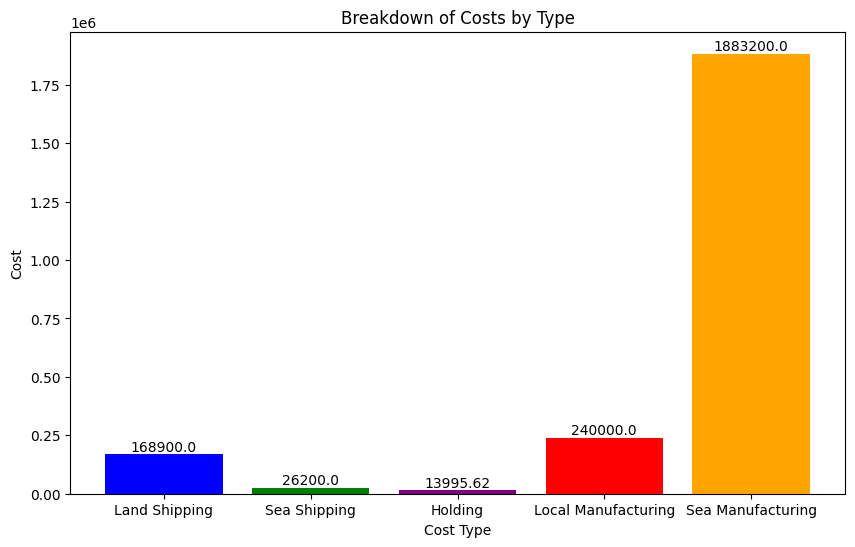

In [143]:
import matplotlib.pyplot as plt

# Calculate costs
land_shipping_cost = sum(R[i][j] * X_values[i][j] for i in cities for j in cities)
sea_shipping_cost = sum(S_L[i] * (alpha_values[i] + eL_values[i]) + S_S[i] * (beta_values[i] + eS_values[i]) + S_Delta[i] * d_values[i] for i in cities)
local_manufacturing_cost = sum(500 * z_values[i] * m[i] for i in cities)
sea_manufacturing_cost = sum(Y_values[i] * m["Ovis"] for i in cities)
holding_cost = sum(0.15/365 * L[i] * m["Ovis"] * ((alpha_values[i] + eL_values[i]) * 200 + (beta_values[i] + eS_values[i]) * 100) for i in cities)

# Create a dictionary to store the costs
costs = {
    'Land Shipping': land_shipping_cost,
    'Sea Shipping': sea_shipping_cost,
    'Local Manufacturing': local_manufacturing_cost,
    'Sea Manufacturing': sea_manufacturing_cost,
    'Holding': holding_cost
}

# Plot the costs
plt.figure(figsize=(10, 6))
bars1 = plt.bar(['Land Shipping', 'Sea Shipping', 'Holding'], [costs['Land Shipping'], costs['Sea Shipping'], costs['Holding']], color=['blue', 'green', 'purple'])
bars2 = plt.bar(['Local Manufacturing', 'Sea Manufacturing'], [costs['Local Manufacturing'], costs['Sea Manufacturing']], color=['red', 'orange'])

plt.xlabel('Cost Type')
plt.ylabel('Cost')
plt.title('Breakdown of Costs by Type')

# Add labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

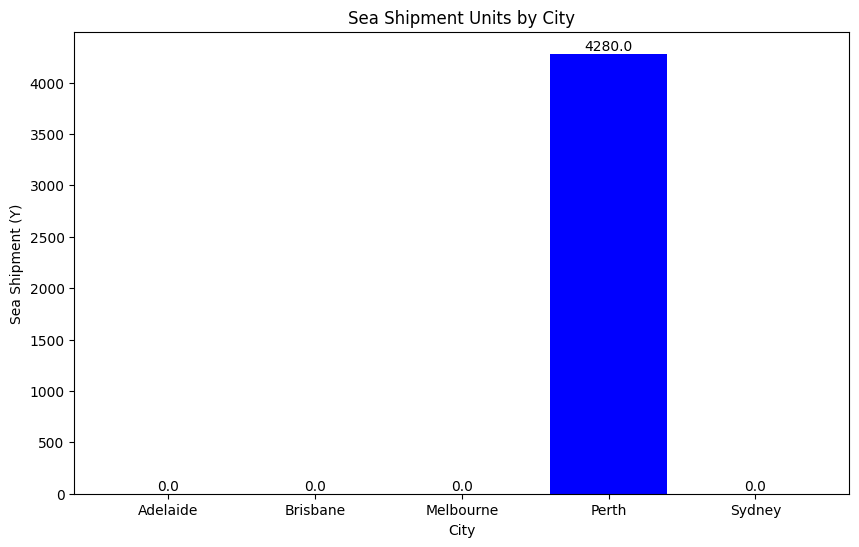

In [144]:
import matplotlib.pyplot as plt

# Plot the sea shipment values
plt.figure(figsize=(10, 6))
bars = plt.bar(Y_values.keys(), Y_values.values(), color='blue')
plt.xlabel('City')
plt.ylabel('Sea Shipment (Y)')
plt.title('Sea Shipment Units by City')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

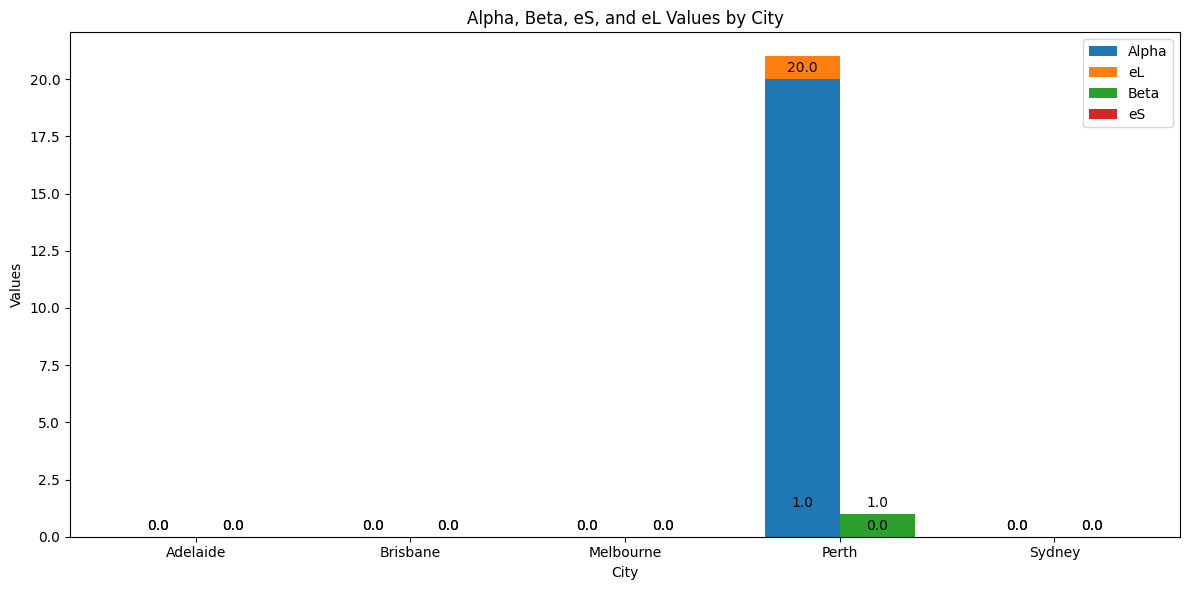

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
alpha_vals = [alpha_values[city] for city in cities]
beta_vals = [beta_values[city] for city in cities]
eS_vals = [eS_values[city] for city in cities]
eL_vals = [eL_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Stacked bars for alpha and eL
rects1 = ax.bar(x, alpha_vals, width, label='Alpha')
rects2 = ax.bar(x, eL_vals, width, bottom=alpha_vals, label='eL')

# Separate bars for beta and eS
rects3 = ax.bar(x + width, beta_vals, width, label='Beta')
rects4 = ax.bar(x + width, eS_vals, width, bottom=beta_vals, label='eS')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Values')
ax.set_title('Alpha, Beta, eS, and eL Values by City')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

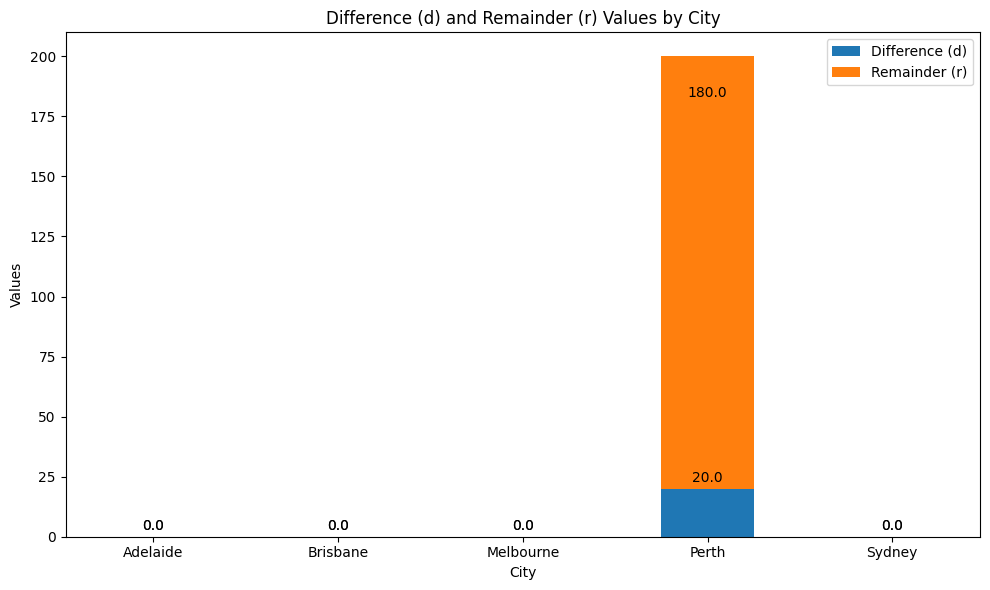

In [146]:
import numpy as np

import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
d_vals = [d_values[city] for city in cities]
r_vals = [r_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for d and r
rects1 = ax.bar(x, d_vals, width, label='Difference (d)')
rects2 = ax.bar(x, r_vals, width, bottom=d_vals, label='Remainder (r)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Values')
ax.set_title('Difference (d) and Remainder (r) Values by City')
ax.set_xticks(x)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

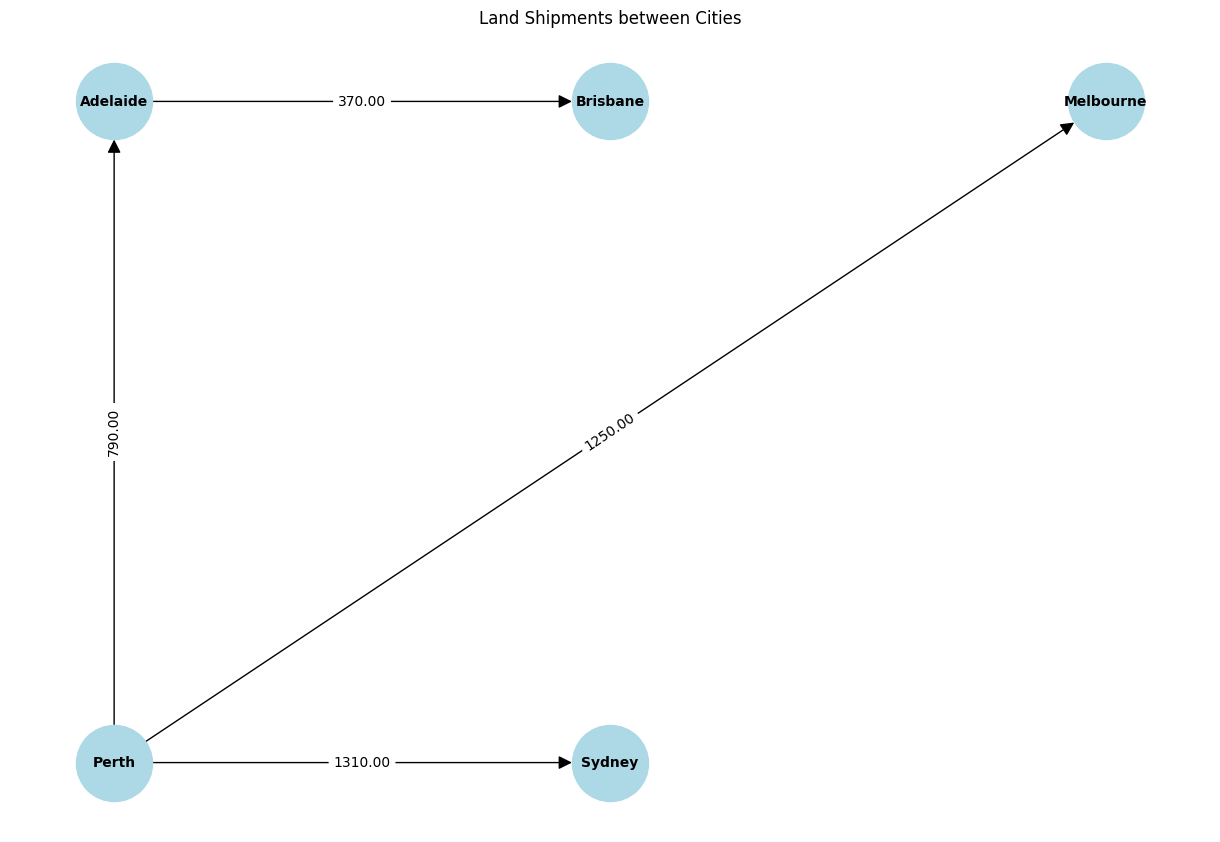

In [147]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges with flow values as labels
for i in cities:
    for j in cities:
        if i != j and X_values[i][j] > 0:  # Only add edges with positive flow
            G.add_edge(i, j, weight=X_values[i][j])

# Define custom positions for the nodes to equally space them
pos = {
    'Adelaide': (0, 1),
    'Brisbane': (1, 1),
    'Melbourne': (2, 1),
    'Perth': (0, 0),
    'Sydney': (1, 0)
}

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)

# Draw edge labels
edge_labels = {(i, j): f'{X_values[i][j]:.2f}' for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Land Shipments between Cities")
plt.show()

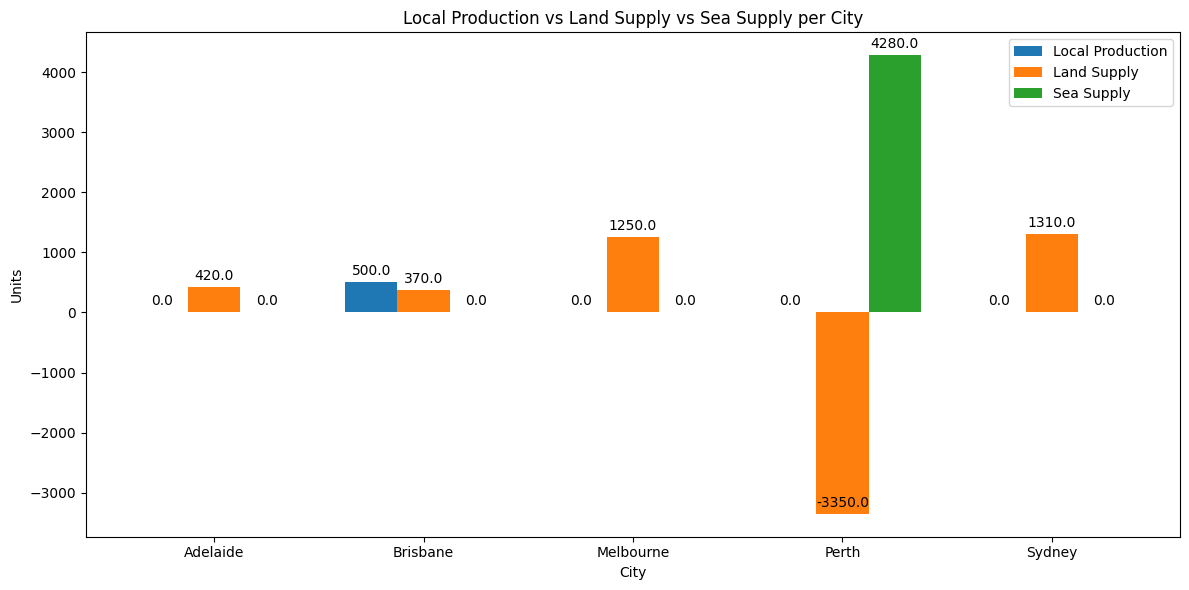

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
local_production = [z_values[city] * 500 for city in cities]
imported_production = [sum(X_values[other_city][city] - X_values[city][other_city] for other_city in cities if other_city != city) for city in cities]
sea_supply = [Y_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, local_production, width, label='Local Production')
rects2 = ax.bar(x, imported_production, width, label='Land Supply')
rects3 = ax.bar(x + width, sea_supply, width, label='Sea Supply')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Units')
ax.set_title('Local Production vs Land Supply vs Sea Supply per City')
ax.set_xticks(x)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


---

# Let's compare to when we don't manufacture.

$$
Z=0\\
X=0
$$
---

In [149]:
# Add constraints to set X and z to 0
for i in cities:
    for j in cities:
        model.addConstr(X[i, j] == 0, name=f"SetXtoZero_{i}_{j}")

for i in cities:
    model.addConstr(z[i] == 0, name=f"SetZtoZero_{i}")

# Optimize Model again
model.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 106 rows, 65 columns and 190 nonzeros
Model fingerprint: 0x764f1cb8
Variable types: 0 continuous, 65 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint SetXtoZero_Adelaide_Brisbane by 370.000000000

Presolve removed 103 rows and 60 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 8 nonzeros
Variable types: 0 continuous, 5 integer (2 binary)
Found heuristic solution: objective 1.053750e+07
Found heuristic solution: objective 1.032790e+07
Found heuristic solution: objective 1.032745e+07
Found heuristic solution: objective 1.

In [150]:
# Print Results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    print(f"Total Cost: {model.objVal}")
    
    # Collect results
    X_values = {i: {j: X[i, j].x for j in cities} for i in cities}
    Y_values = {i: Y[i].x for i in cities}
    z_values = {i: z[i].x for i in cities}
    eS_values = {i: eS[i].x for i in cities}
    eL_values = {i: eL[i].x for i in cities}
    alpha_values = {i: alpha[i].x for i in cities}
    beta_values = {i: beta[i].x for i in cities}
    d_values = {i: d[i].x for i in cities}
    r_values = {i: r[i].x for i in cities}

    # Print results
    print("X values (Land shipping):", X_values)
    print("Y values (Sea shipping):", Y_values)
    print("z values (Production indicator):", z_values)
    print("eS values (Small extra container indicator):", eS_values)
    print("eL values (Large extra container indicator):", eL_values)
    print("alpha values (Large container count):", alpha_values)
    print("beta values (Small container count):", beta_values)
    print("d values (Difference variable):", d_values)
    print("r values (Remainder variable):", r_values)

else:
    print("No optimal solution found.")


Optimal solution found:
Total Cost: 10289830.0
X values (Land shipping): {'Adelaide': {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 0.0, 'Perth': 0.0, 'Sydney': 0.0}, 'Brisbane': {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 0.0, 'Perth': 0.0, 'Sydney': 0.0}, 'Melbourne': {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 0.0, 'Perth': 0.0, 'Sydney': 0.0}, 'Perth': {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 0.0, 'Perth': 0.0, 'Sydney': 0.0}, 'Sydney': {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 0.0, 'Perth': 0.0, 'Sydney': 0.0}}
Y values (Sea shipping): {'Adelaide': 420.0, 'Brisbane': 870.0, 'Melbourne': 1250.0, 'Perth': 930.0, 'Sydney': 1310.0}
z values (Production indicator): {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 0.0, 'Perth': 0.0, 'Sydney': 0.0}
eS values (Small extra container indicator): {'Adelaide': 1.0, 'Brisbane': 1.0, 'Melbourne': 1.0, 'Perth': 0.0, 'Sydney': -0.0}
eL values (Large extra container indicator): {'Adelaide': 0.0, 'Brisbane': 0.0, 'Melbourne': 

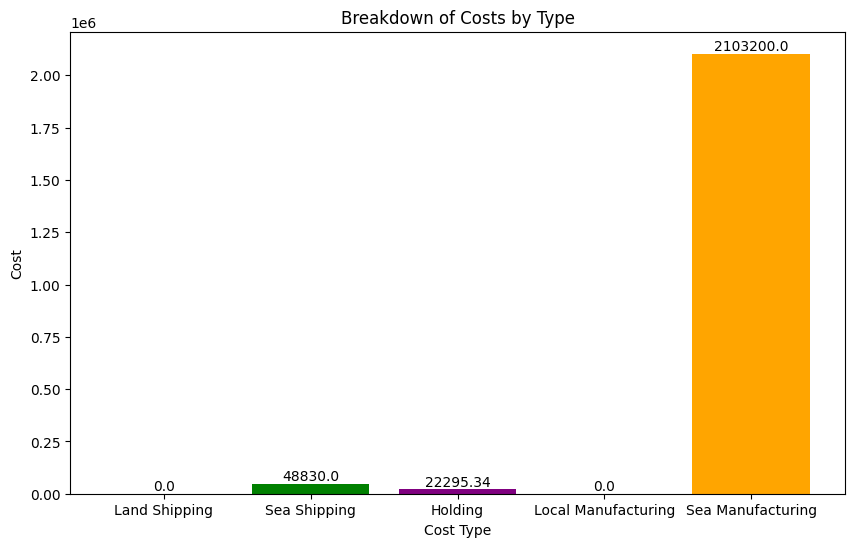

In [151]:
import matplotlib.pyplot as plt

# Calculate costs
land_shipping_cost = sum(R[i][j] * X_values[i][j] for i in cities for j in cities)
sea_shipping_cost = sum(S_L[i] * (alpha_values[i] + eL_values[i]) + S_S[i] * (beta_values[i] + eS_values[i]) + S_Delta[i] * d_values[i] for i in cities)
local_manufacturing_cost = sum(500 * z_values[i] * m[i] for i in cities)
sea_manufacturing_cost = sum(Y_values[i] * m["Ovis"] for i in cities)
holding_cost = sum(0.15/365 * L[i] * m["Ovis"] * ((alpha_values[i] + eL_values[i]) * 200 + (beta_values[i] + eS_values[i]) * 100) for i in cities)

# Create a dictionary to store the costs
costs = {
    'Land Shipping': land_shipping_cost,
    'Sea Shipping': sea_shipping_cost,
    'Local Manufacturing': local_manufacturing_cost,
    'Sea Manufacturing': sea_manufacturing_cost,
    'Holding': holding_cost
}

# Plot the costs
plt.figure(figsize=(10, 6))
bars1 = plt.bar(['Land Shipping', 'Sea Shipping', 'Holding'], [costs['Land Shipping'], costs['Sea Shipping'], costs['Holding']], color=['blue', 'green', 'purple'])
bars2 = plt.bar(['Local Manufacturing', 'Sea Manufacturing'], [costs['Local Manufacturing'], costs['Sea Manufacturing']], color=['red', 'orange'])

plt.xlabel('Cost Type')
plt.ylabel('Cost')
plt.title('Breakdown of Costs by Type')

# Add labels on top of each bar
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

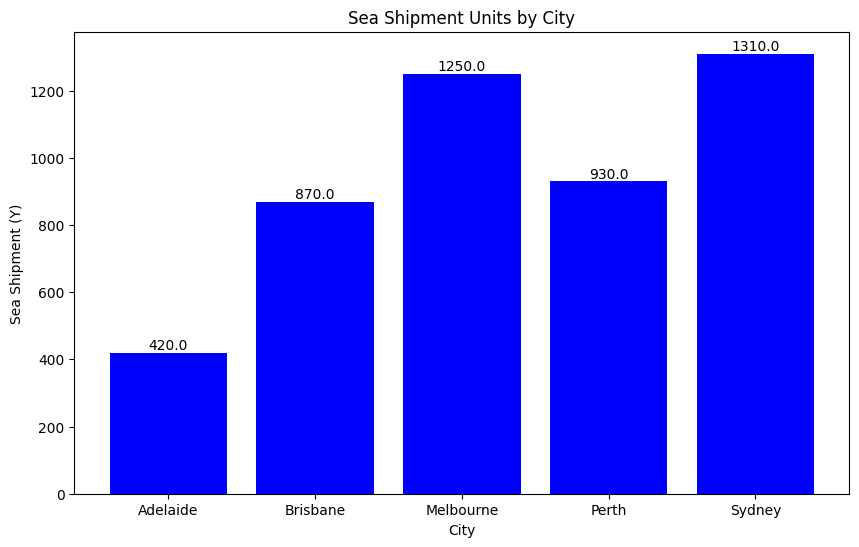

In [152]:
import matplotlib.pyplot as plt

# Plot the sea shipment values
plt.figure(figsize=(10, 6))
bars = plt.bar(Y_values.keys(), Y_values.values(), color='blue')
plt.xlabel('City')
plt.ylabel('Sea Shipment (Y)')
plt.title('Sea Shipment Units by City')

# Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

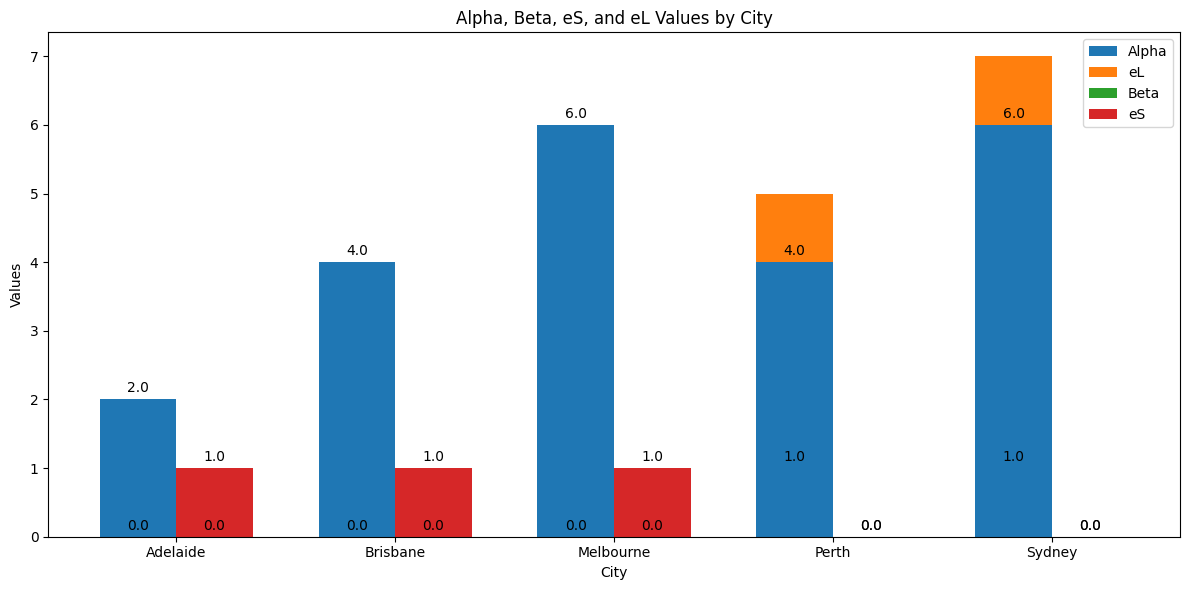

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
alpha_vals = [alpha_values[city] for city in cities]
beta_vals = [beta_values[city] for city in cities]
eS_vals = [eS_values[city] for city in cities]
eL_vals = [eL_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Stacked bars for alpha and eL
rects1 = ax.bar(x, alpha_vals, width, label='Alpha')
rects2 = ax.bar(x, eL_vals, width, bottom=alpha_vals, label='eL')

# Separate bars for beta and eS
rects3 = ax.bar(x + width, beta_vals, width, label='Beta')
rects4 = ax.bar(x + width, eS_vals, width, bottom=beta_vals, label='eS')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Values')
ax.set_title('Alpha, Beta, eS, and eL Values by City')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

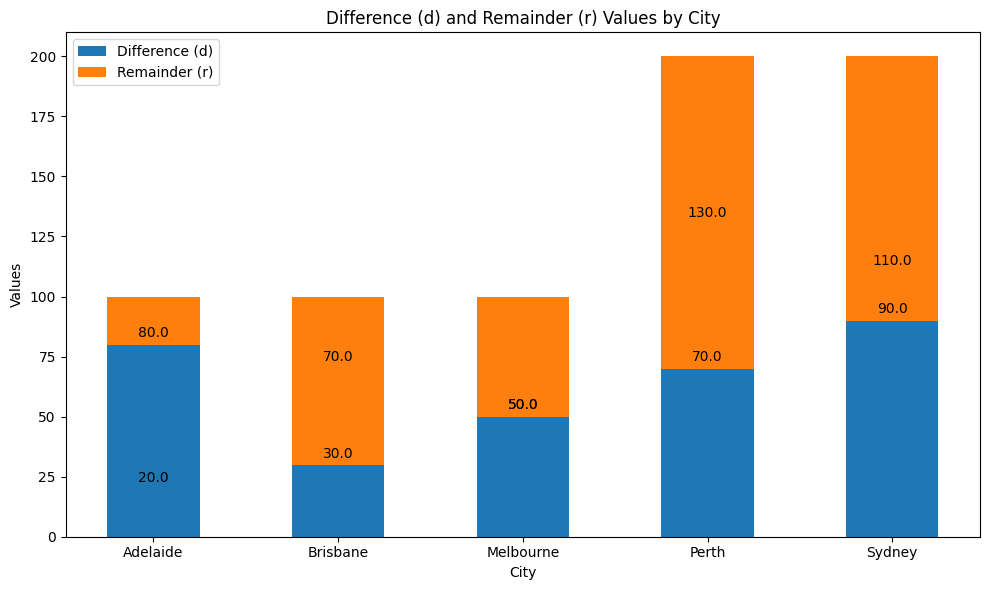

In [154]:
import numpy as np

import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
d_vals = [d_values[city] for city in cities]
r_vals = [r_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars for d and r
rects1 = ax.bar(x, d_vals, width, label='Difference (d)')
rects2 = ax.bar(x, r_vals, width, bottom=d_vals, label='Remainder (r)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Values')
ax.set_title('Difference (d) and Remainder (r) Values by City')
ax.set_xticks(x)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

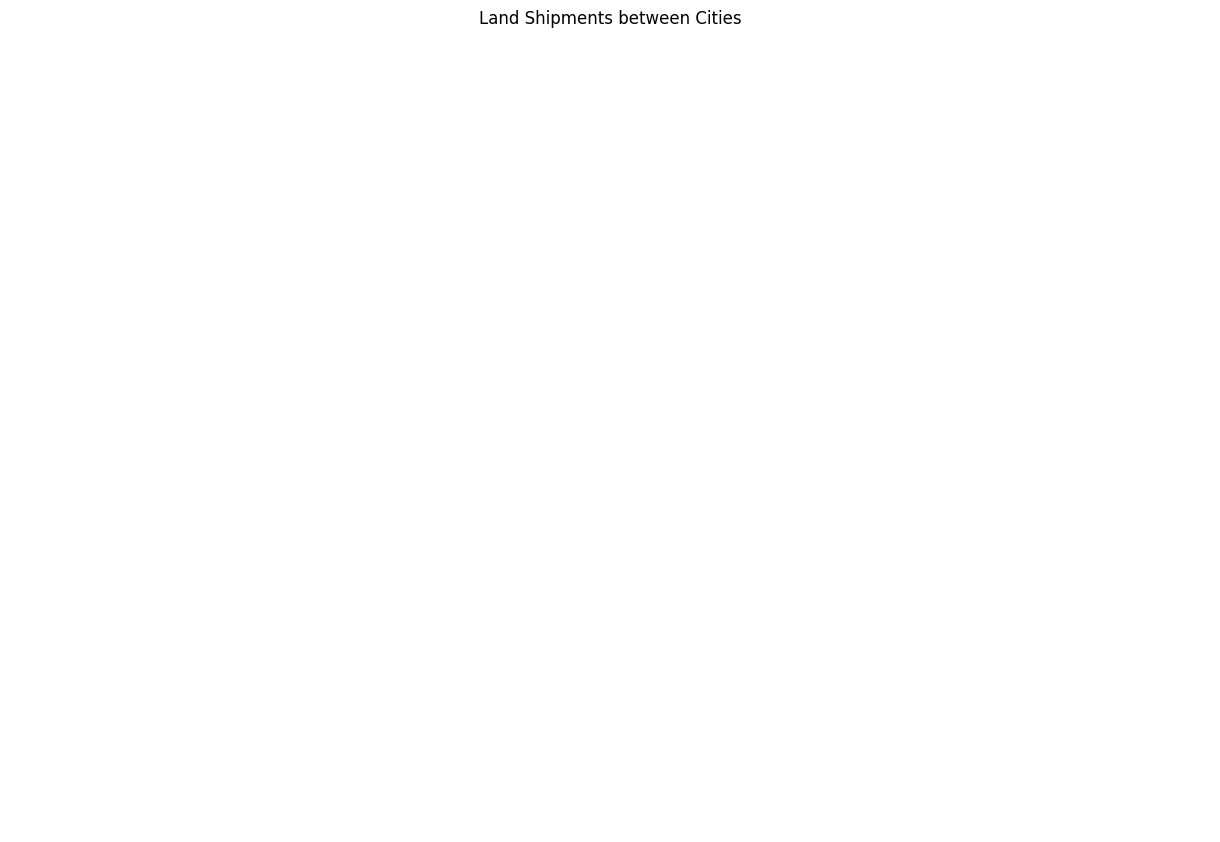

In [155]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges with flow values as labels
for i in cities:
    for j in cities:
        if i != j and X_values[i][j] > 0:  # Only add edges with positive flow
            G.add_edge(i, j, weight=X_values[i][j])

# Define custom positions for the nodes to equally space them
pos = {
    'Adelaide': (0, 1),
    'Brisbane': (1, 1),
    'Melbourne': (2, 1),
    'Perth': (0, 0),
    'Sydney': (1, 0)
}

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)

# Draw edge labels
edge_labels = {(i, j): f'{X_values[i][j]:.2f}' for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Land Shipments between Cities")
plt.show()

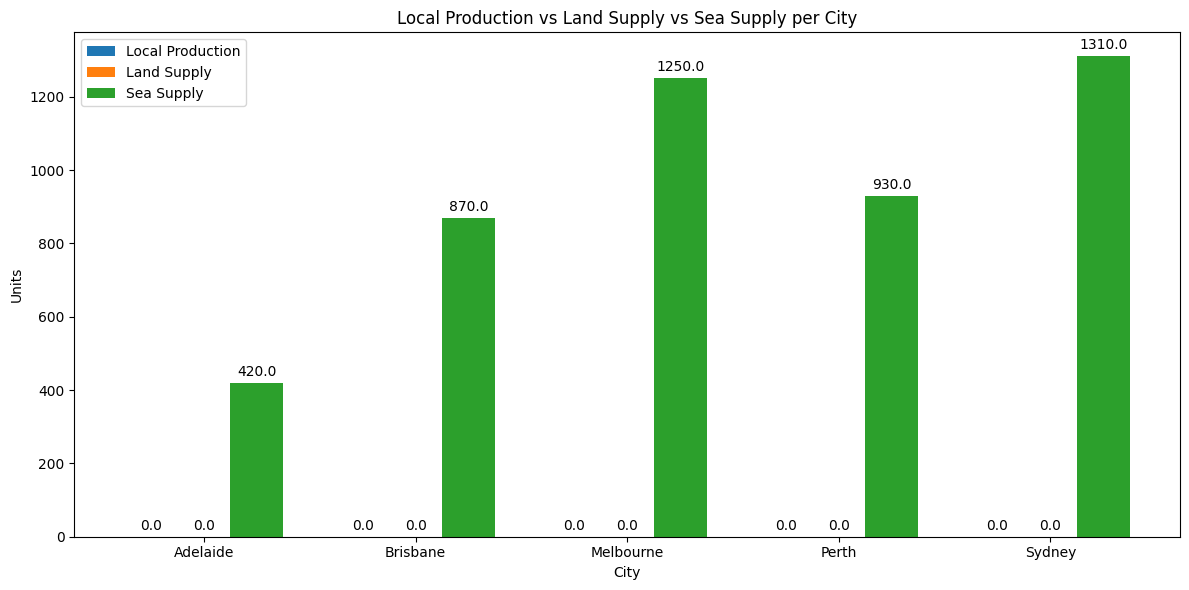

In [156]:
import numpy as np
import matplotlib.pyplot as plt

# Data
cities = ['Adelaide', 'Brisbane', 'Melbourne', 'Perth', 'Sydney']
local_production = [z_values[city] * 500 for city in cities]
imported_production = [sum(X_values[other_city][city] - X_values[city][other_city] for other_city in cities if other_city != city) for city in cities]
sea_supply = [Y_values[city] for city in cities]

# Plotting
x = np.arange(len(cities))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, local_production, width, label='Local Production')
rects2 = ax.bar(x, imported_production, width, label='Land Supply')
rects3 = ax.bar(x + width, sea_supply, width, label='Sea Supply')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('City')
ax.set_ylabel('Units')
ax.set_title('Local Production vs Land Supply vs Sea Supply per City')
ax.set_xticks(x)
ax.set_xticklabels(cities)
ax.legend()

# Add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


# Cost-Benefit Analysis of Engaging Domes (Monthly Basis)

---

## 1. How much does it cost for Oz Sourcing to ship directly from Ovis to each city?

In **Scenario B**, Domes is *not* engaged (no local manufacturing). All demands are satisfied via **direct sea shipments** from Ovis to each Australian city. The model’s optimal solution yields:

- **Total Cost** = \$10,289,830

Under these constraints (no production in any Australian city), the solution confirms that **direct shipping from Ovis to each city** is the best possible approach. Specifically, the model sets:
- $ X_{ij} = 0 $ (no land shipments within Australia)
- $ z_i = 0 $ (no local production)
- All demand in each city is met by $ Y_j $ (units shipped from Ovis).

Hence, **10.29M** per month is the benchmark if Oz Sourcing relies solely on Ovis for production and ships directly to each city.

---

## 2. If Oz Sourcing does not engage Domes, is the current shipping practice best for Ovis?

Yes. When Domes is *not* engaged (i.e., no local manufacturing option), the model confirms that the **least-cost** solution is to ship directly from Ovis to each city. No further cost savings appear possible by routing through any single city or combining land shipments among the cities (the optimal solution indeed results in zero land shipments).

Thus, the **current direct-shipping practice** is validated as the best option if Domes is not involved.

---

## 3. In which city should Oz Sourcing ask Domes to manufacture?

In **Scenario A**, we allow Domes to manufacture in exactly one Australian city (i.e., $\sum_i z_i \le 1$). The model’s optimal solution chooses:

- **Brisbane** ($z_{\text{Brisbane}} = 1$)

Even though Adelaide has a slightly lower unit manufacturing cost (450 vs. 480 for Brisbane), Brisbane’s **geographic position** and **land-shipping costs** to other cities make it the overall cheapest production site. In other words, **Brisbane** strikes the best balance between production cost and distribution cost.

The resulting total monthly cost (with Brisbane producing 500 units for its own demand and some additional flows) is:

- **Total Cost** = \$7,426,700 

Within that solution, the model also decides to **ship a large portion of product via sea into Perth** (4,280 units), which is then redistributed by land to Adelaide, Melbourne, and Sydney. This combination leverages Perth’s favorable container-shipping cost from Ovis plus the local production in Brisbane.

---

## 4. How much could Oz Sourcing save, if engaging Domes proves to be cost-beneficial?

By comparing **Scenario A** (with Domes manufacturing in Brisbane) vs. **Scenario B** (no local manufacturing):

- **Cost with Domes (Scenario A):** 7,426,700  
- **Cost without Domes (Scenario B):** 10,289,830  

**Monthly Savings** = 10,289,830 − 7,426,700 ≈ **2,863,130**

Thus, **engaging Domes** in Brisbane reduces total monthly costs by nearly **2.86 million**. This significant cost reduction highlights the benefit of local production (in Brisbane) plus selective sea shipments (especially into Perth) versus direct shipment of all units from Ovis to each city.

---